https://drlee.io/market-basket-analysis-with-python-a-beginners-guide-to-apriori-and-mlxtend-c04725aa2c4d



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys 
sys.path.append("../")

from src import soporte_exploracion as se
pd.set_option('display.max_columns', None)


# Análisis exploratorio analítico

In [14]:
# cargamos el conjunto de datos
df = pd.read_excel('../data/retail.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [15]:
# hago el analisis exploratorio de datos usando la funcion almacenada en la carpeta de src
se.exploracion_dataframe(df)


El dataframe tiene 525461 filas y 8 columnas.
------------------------------------------------------------
Filas duplicadas: 6865 que corresponde con un 1.31 % del total de los datos
------------------------------------------------------------
Columnas con valores nulos (%):


,%_nulos
Customer ID,20.539488
Description,0.557225


------------------------------------------------------------
Tipos de datos:


,tipo_dato
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object


------------------------------------------------------------
No hay columnas constantes.
------------------------------------------------------------
Columnas categóricas: ['Invoice', 'StockCode', 'Description', 'Country']

INVOICE - valores únicos:


Invoice
537434    675
538071    652
537638    601
537237    597
536876    593
536592    592
537823    591
536031    582
490074    580
491966    579
Name: count, dtype: int64


STOCKCODE - valores únicos:


StockCode
85123A    3516
22423     2221
85099B    2057
21212     1933
21232     1843
20725     1620
84879     1458
84991     1400
21754     1386
20914     1276
Name: count, dtype: int64


DESCRIPTION - valores únicos:


Description
WHITE HANGING HEART T-LIGHT HOLDER    3549
NaN                                   2928
REGENCY CAKESTAND 3 TIER              2212
STRAWBERRY CERAMIC TRINKET BOX        1843
PACK OF 72 RETRO SPOT CAKE CASES      1466
ASSORTED COLOUR BIRD ORNAMENT         1457
60 TEATIME FAIRY CAKE CASES           1400
HOME BUILDING BLOCK WORD              1386
JUMBO BAG RED RETROSPOT               1310
LUNCH BAG RED SPOTTY                  1274
Name: count, dtype: int64


COUNTRY - valores únicos:


Country
United Kingdom     485852
EIRE                 9670
Germany              8129
France               5772
Netherlands          2769
Spain                1278
Switzerland          1187
Portugal             1101
Belgium              1054
Channel Islands       906
Name: count, dtype: int64

------------------------------------------------------------
Estadísticas de columnas numéricas:


,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0,10.337667,107.424110,-9600.00,1.00,3.0,10.00,19152.00
Price,525461.0,4.688834,146.126914,-53594.36,1.25,2.1,4.21,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.00,13983.00,15311.0,16799.00,18287.00


------------------------------------------------------------


#### Conclusiones del análisis exploratorio de datos


- El dataset cuenta con más de **525k registros** y **8 columnas**, incluyendo identificadores de factura (`Invoice`) y producto (`StockCode`), esenciales para MBA.

- Se detectaron **filas duplicadas**, que deben eliminarse para evitar inflar la frecuencia de productos en las cestas.

- La variable `Customer ID` tiene más del 20% de valores nulos, pero no es crítica para el análisis de cestas, ya que este se centra en el nivel de factura.

- Algunas transacciones tienen **valores negativos en `Quantity` y `Price`**, probablemente por devoluciones, lo que puede alterar la construcción de las cestas si no se filtran.

- Hay productos con descripciones faltantes y codificaciones que podrían necesitar normalización si se usan como etiquetas.

**Conclusiones clave para el Basket Analysis**

- `Invoice` actúa como identificador de transacción, lo que permite agrupar productos comprados juntos.

- La mayoría de las transacciones provienen del **Reino Unido**, por lo que si se incluyen todos los países, conviene segmentar o normalizar.

- La existencia de devoluciones puede generar transacciones “vacías” o con cantidades negativas si no se trata adecuadamente.

- Algunas facturas aparecen muchas veces, lo que sugiere compras múltiples en una misma sesión (ideal para MBA).



In [16]:
df[df["Price"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [17]:
df[df["Quantity"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [18]:
# me doy cuenta de que el value counts de los codigos de productos no coinciden con los de la descripcion. Por lo que algo debe ocurrir.
print(df[df["StockCode"].str.contains("85123", na = False)]["StockCode"].unique())

# al hacer el filtro veo que algunis codigos están en mayuscula y otros en minuscula, por lo que voy a homogeneizarlo
df["StockCode"] = df["StockCode"].str.upper()
df["Description"] = df["Description"].str.upper()

['85123A' '85123b' '85123a']


In [19]:
df["StockCode"].value_counts()

StockCode
85123A      3550
85099B      2082
82494L      1192
85099F      1091
85099C      1002
            ... 
72348B         1
DCGS0060       1
84810C         1
84750C         1
79151B         1
Name: count, Length: 1524, dtype: int64

In [20]:
df["Description"].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER     3549
REGENCY CAKESTAND 3 TIER               2212
STRAWBERRY CERAMIC TRINKET BOX         1843
PACK OF 72 RETRO SPOT CAKE CASES       1466
ASSORTED COLOUR BIRD ORNAMENT          1457
                                       ... 
EBAY SALES BY THE BOX.                    1
RUSTY CONNECTIONS                         1
STOCK CREDITED FROM ROYAL YACHT INC       1
CORRECT PREVIOUS ADJUSTMENT               1
FAULTY                                    1
Name: count, Length: 4669, dtype: int64

In [21]:
df[df["Description"]=="INCORRECTLY ENTERED. SHOULD BE 2279"]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
395005,527346,NaN,INCORRECTLY ENTERED. SHOULD BE 2279,-720,2010-10-15 15:48:00,0.0,NaN,United Kingdom


In [39]:
# voy a filtar el conjunto de datos para eliminar los valores negativos de la columna 'Quantity" y evitar malas interpretaciones en lo que me queda de análisis exploratorio
condicion1 = df["Price"] >= 1
condicion2 = df["Quantity"] >= 0

df = df[condicion1 & condicion2].sort_values(by = "Price")

# Analisis exploratorio visual

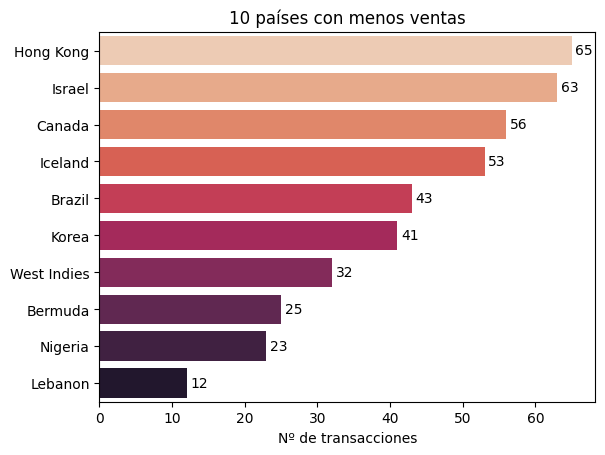

In [67]:
# numero de ventas por pais
df_pais = df.groupby(["Country"])["Invoice"].count().reset_index().sort_values(by = "Invoice", ascending = False)

# ploteamos los 10 paises con menos ventas
sns.barplot(y = "Country", 
            x = "Invoice", 
            data = df_pais.tail(10), 
            palette = "rocket_r", 
            hue = "Country")
plt.title("10 países con menos ventas")
plt.xlabel("Nº de transacciones")
plt.ylabel("")

# Añadir anotaciones a cada barra
for i, (valor, pais) in enumerate(zip(df_pais.tail(10)["Invoice"], df_pais.tail(10)["Country"])):
    plt.text(valor + 0.5,  # un poco a la derecha de la barra
             i,           # posición vertical (índice)
             f"{valor:.0f}",  # el texto a mostrar (sin decimales)
             va='center')     # alineación vertical

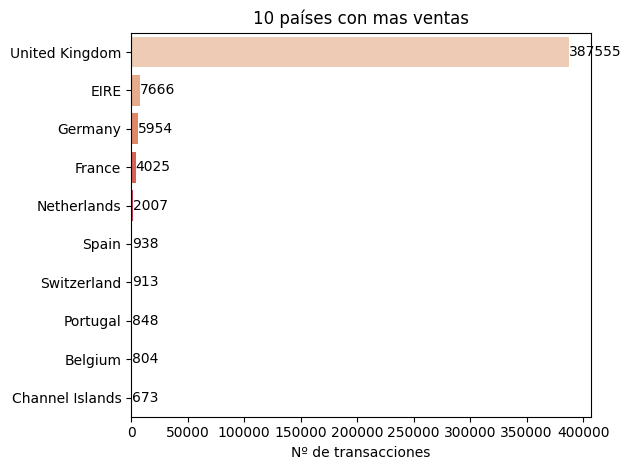

In [66]:
# ploteamos los 10 paises con mas ventas
sns.barplot(y = "Country", 
            x = "Invoice", 
            data = df_pais.head(10),
            palette = "rocket_r", 
            hue = "Country")
plt.title("10 países con mas ventas")
plt.xlabel("Nº de transacciones")
plt.ylabel("")


# Añadir anotaciones a cada barra
for i, (valor, pais) in enumerate(zip(df_pais.head(10)["Invoice"], df_pais.head(10)["Country"])):
    plt.text(valor + 0.5,  # un poco a la derecha de la barra
             i,           # posición vertical (índice)
             f"{valor:.0f}",  # el texto a mostrar (sin decimales)
             va='center')     # alineación vertical

plt.tight_layout()

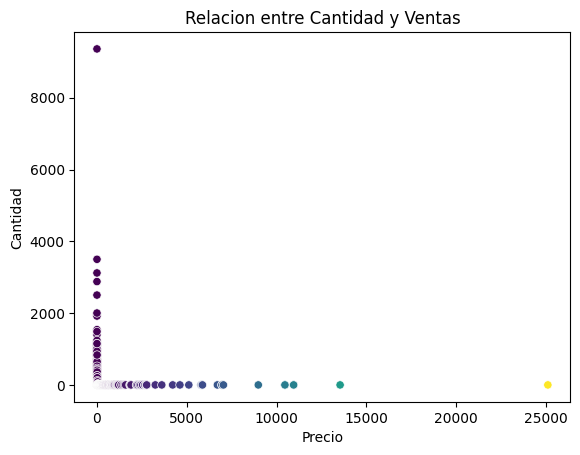

In [76]:
# relacion entre precio y cantidad
sns.scatterplot(x = "Price", 
                y = "Quantity", 
                data = df,
                palette = "viridis", 
                hue = "Price", 
                legend = False)
plt.title("Relacion entre Cantidad y Ventas")
plt.ylabel("Cantidad")
plt.xlabel("Precio");

**Conclusion de la grafica de relacion entre precio y cantidad** 

- **Mayoría de productos**: baratos y con pocas unidades vendidas esto podria sugerir que las reglas de asociación más fuertes saldrán de estos productos.

- **Outliers**: precios muy altos (> 20,000) o cantidades muy grandes (> 9,000) → Considerar eliminarlos o analizarlos aparte (ventas atípicas o mayoristas).

- **No parece que haya una relación clara** entre precio y cantidad → Agrupar productos por categorías puede ser más útil para encontrar patrones.

Por lo tanto, para un análisis efectivo:

- Filtrar *outliers* antes de aplicar reglas de asociación.

- Usar productos comunes y frecuentes como base.


In [77]:
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
461648,533027,NaN,PACK OF 12 PINK POLKADOT TISSUES,56,2010-11-15 16:02:00,1.0,NaN,United Kingdom
143628,503061,NaN,MINI JIGSAW CIRCUS PARADE,12,2010-03-29 16:47:00,1.0,NaN,United Kingdom


In [85]:
df_cantidad.head()

,Description,Quantity
3986,WHITE HANGING HEART T-LIGHT HOLDER,58792
253,ASSORTED COLOUR BIRD ORNAMENT,45188
1942,JUMBO BAG RED RETROSPOT,30805
3679,STRAWBERRY CERAMIC TRINKET BOX,27127
3144,ROTATING SILVER ANGELS T-LIGHT HLDR,23049


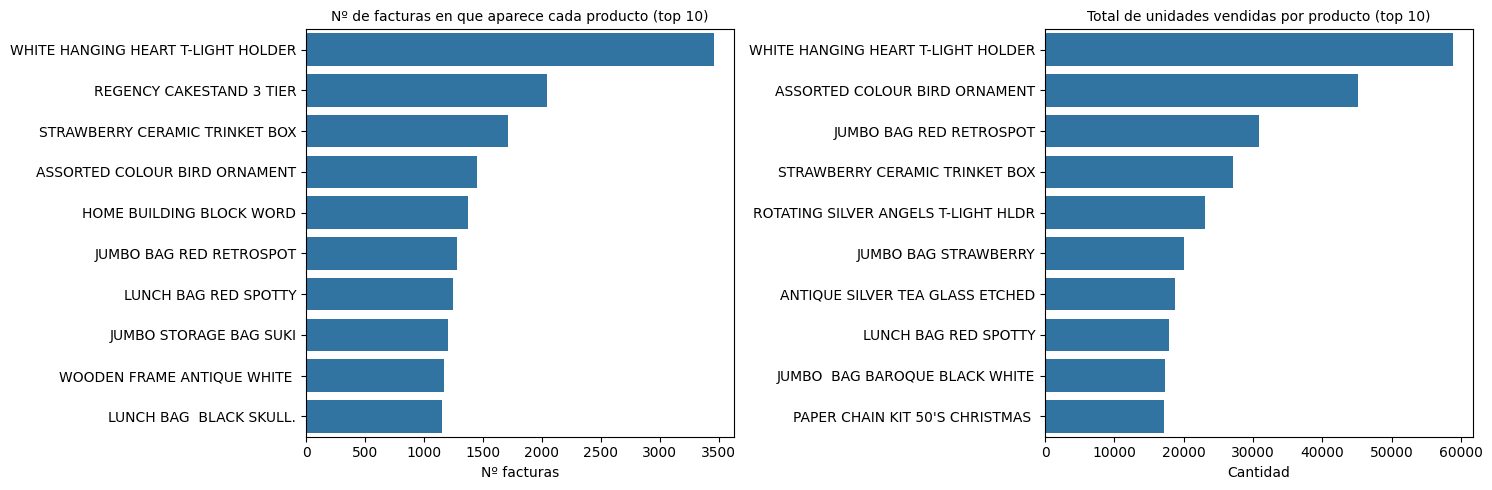

In [98]:
# productos mas vendidos por cantidad y por frecuencia (cantidad de facturas)

df_cantidad = df.groupby("Description")["Quantity"].sum().reset_index().sort_values(by = "Quantity", ascending = False )
df_frecuencia = df.groupby("Description")["Invoice"].count().reset_index().sort_values(by = "Invoice", ascending = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

sns.barplot(x = "Invoice", y = "Description", data = df_frecuencia.head(10), ax = axes[0])
sns.barplot(x = "Quantity", y = "Description", data = df_cantidad.head(10), ax = axes[1])

axes[0].set_ylabel("")
axes[1].set_ylabel("")

axes[0].set_xlabel("Nº facturas")
axes[1].set_xlabel("Cantidad")

axes[0].set_title("Nº de facturas en que aparece cada producto (top 10)", fontsize = 10)
axes[1].set_title("Total de unidades vendidas por producto (top 10)",  fontsize = 10)

plt.tight_layout()

**Conclusiones de esta gráfica**

- `WHITE HANGING HEART T-LIGHT HOLDER` lidera en ambas métricas → producto estrella para recomendaciones.

- **No todos los productos coinciden** en ambos tops:

  - Algunos son muy **frecuentes** (aparecen en muchas cestas), pero se venden en pocas unidades → ideales para promociones cruzadas.

  - Otros tienen **mucho volumen**, pero aparecen en menos tickets → pueden ser compras masivas o por stock.

**¿Qué implicaciones tiene esto para nuestro analisis?**

- Usar los productos más **frecuentes** como base para reglas (`Apriori`, `FP-Growth`).

- Analizar los de **alto volumen** por separado, podrían responder a clientes o eventos distintos.

- Considerar agrupar productos por tipo o categoría para reglas más generalizables.

In [105]:
df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
461648,533027,NaN,PACK OF 12 PINK POLKADOT TISSUES,56,2010-11-15 16:02:00,1.0,NaN,United Kingdom
143628,503061,NaN,MINI JIGSAW CIRCUS PARADE,12,2010-03-29 16:47:00,1.0,NaN,United Kingdom
143711,503061,NaN,"ELEPHANT, BIRTHDAY CARD,",57,2010-03-29 16:47:00,1.0,NaN,United Kingdom
461629,533027,NaN,MAGIC DRAWING SLATE DOLLY GIRL,142,2010-11-15 16:02:00,1.0,NaN,United Kingdom
103829,499297,NaN,WAY OUT METAL SIGN,288,2010-02-25 20:16:00,1.0,18102.0,United Kingdom
143710,503061,NaN,VINTAGE KID DOLLY CARD,44,2010-03-29 16:47:00,1.0,NaN,United Kingdom
143709,503061,NaN,GIN & TONIC DIET GREETING CARD,101,2010-03-29 16:47:00,1.0,NaN,United Kingdom
138595,502660,M,MANUAL,6,2010-03-25 17:18:00,1.0,13187.0,United Kingdom
143688,503061,NaN,SPACEBOY BIRTHDAY CARD,93,2010-03-29 16:47:00,1.0,NaN,United Kingdom
284040,516967,POST,POSTAGE,3,2010-07-26 09:50:00,1.0,12813.0,Netherlands


In [116]:
# ventas por mes y año
# primero convierto a datetime la columna de la fecha de la factura
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# creo una columna nueva con el mes de la compra y el año
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year


# calculo el nº de facturas por mes
df_ventas_por_mes = df.groupby('Month')['InvoiceDate'].nunique().reset_index()
df_ventas_por_mes.columns = ['Mes', 'Nº de ventas']

df_ventas_por_mes_anyo = df.groupby(['Year', 'Month'])['InvoiceDate'].nunique().reset_index()
df_ventas_por_mes_anyo.columns = ['Año', 'Mes', 'Nº de ventas']

df_ventas_por_mes.head()

,Mes,Nº de ventas
0,1,1034
1,2,1115
2,3,1527
3,4,1334
4,5,1364


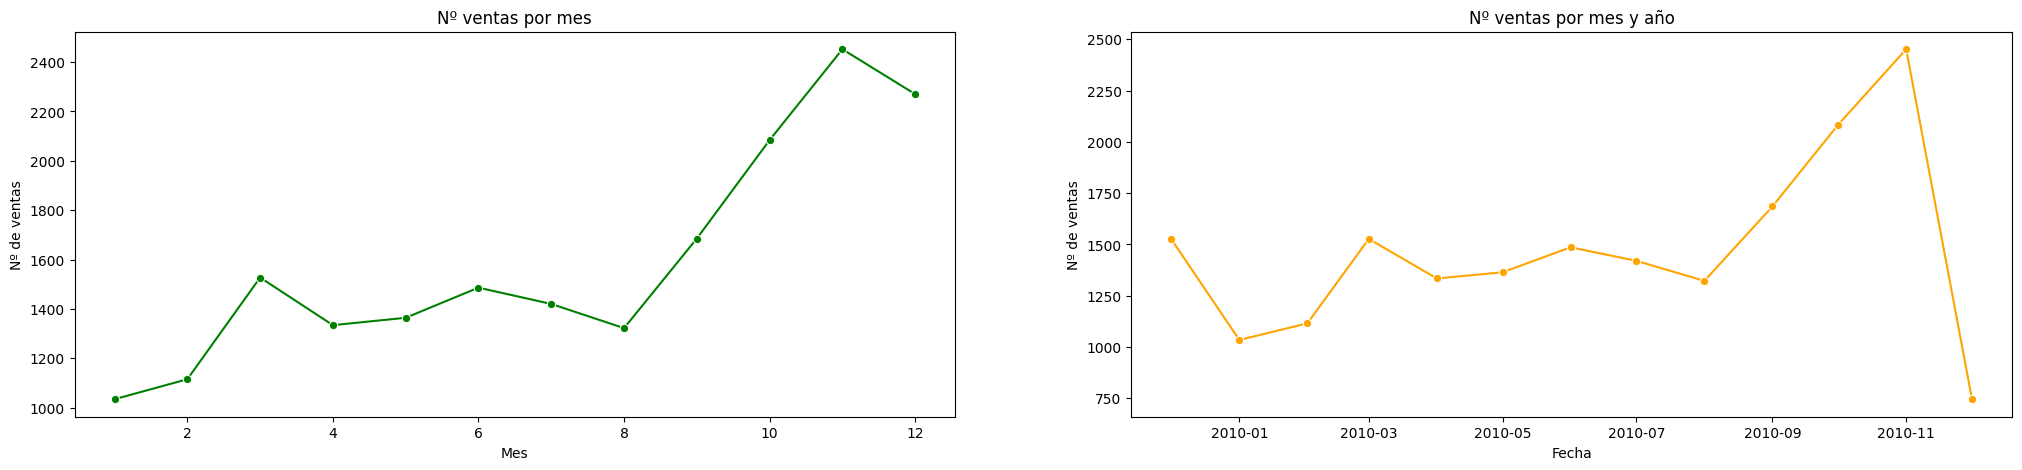

In [127]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 5))
# ventas por mes
sns.lineplot(x = "Mes", 
             y = "Nº de ventas", 
             data = df_ventas_por_mes, 
             marker = "o",
             ax = axes[0], 
             color = "green")


# ventas por mes y año
df_ventas_por_mes_anyo['Fecha'] = pd.to_datetime({
    'year': df_ventas_por_mes_anyo['Año'],
    'month': df_ventas_por_mes_anyo['Mes'],
    'day': 1  # Día fijo para construir la fecha
})

sns.lineplot(data=df_ventas_por_mes_anyo, 
             x='Fecha', 
             y='Nº de ventas',
             marker='o', 
             ax = axes[1], 
             color = "orange")

axes[0].set_title("Nº ventas por mes")
axes[1].set_title("Nº ventas por mes y año");
 